In [27]:
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn
import random

def findFiles(path):
    return glob.glob(path)

print(findFiles('D:/datasets/names_data/names/*.txt'))

all_letters = string.ascii = string.ascii_letters + " ,.;"
n_letters = len(all_letters)

# Turn a unicode string to plain ascii
def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn' and c in all_letters)

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('D:/datasets/names_data/names/*txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
    
n_categories = len(all_categories)

print(category_lines['Italian'][:5])

['D:/datasets/names_data/names\\Arabic.txt', 'D:/datasets/names_data/names\\Chinese.txt', 'D:/datasets/names_data/names\\Czech.txt', 'D:/datasets/names_data/names\\Dutch.txt', 'D:/datasets/names_data/names\\English.txt', 'D:/datasets/names_data/names\\French.txt', 'D:/datasets/names_data/names\\German.txt', 'D:/datasets/names_data/names\\Greek.txt', 'D:/datasets/names_data/names\\Irish.txt', 'D:/datasets/names_data/names\\Italian.txt', 'D:/datasets/names_data/names\\Japanese.txt', 'D:/datasets/names_data/names\\Korean.txt', 'D:/datasets/names_data/names\\Polish.txt', 'D:/datasets/names_data/names\\Portuguese.txt', 'D:/datasets/names_data/names\\Russian.txt', 'D:/datasets/names_data/names\\Scottish.txt', 'D:/datasets/names_data/names\\Spanish.txt', 'D:/datasets/names_data/names\\Vietnamese.txt']
Slusarski
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [20]:
# One hot vector
# Find letter index from all_letters, eg. "a" = 0
# DRILL implement your version of one hot vecotor encoding
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [22]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
    
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [23]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.9159, -2.8854, -2.8706, -2.7934, -2.9038, -2.8138, -2.8604, -2.9238,
         -2.9299, -2.7848, -2.9452, -2.8748, -2.9083, -2.8695, -2.9241, -2.9709,
         -2.9992, -2.8803]], grad_fn=<LogSoftmaxBackward>)


In [26]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Italian', 9)


In [28]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Spanish / line = Morales
category = Spanish / line = Picasso
category = Scottish / line = Burns
category = Czech / line = Stepan
category = English / line = Swales
category = English / line = Dukes
category = English / line = Underdown
category = Arabic / line = Hanania
category = Japanese / line = Morisue
category = Scottish / line = Grant


In [30]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    return output, loss.item()

In [31]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 2.6729 Melo / Vietnamese ✗ (Portuguese)
10000 10% (0m 30s) 1.5611 Quang / Chinese ✗ (Vietnamese)
15000 15% (0m 46s) 2.4728 Lindsay / Russian ✗ (Scottish)
20000 20% (1m 2s) 1.2112 Jo / Korean ✓
25000 25% (1m 17s) 0.9614 Thi / Vietnamese ✓
30000 30% (1m 31s) 1.2088 Tanzi / Italian ✓
35000 35% (1m 46s) 3.9781 Mas / Vietnamese ✗ (Spanish)
40000 40% (2m 0s) 0.9323 Hudecek / Czech ✓
45000 45% (2m 15s) 0.1302 Zenkov / Russian ✓
50000 50% (2m 30s) 0.9737 Hong / Chinese ✓
55000 55% (2m 46s) 0.4059 Ryom / Korean ✓
60000 60% (3m 1s) 0.3725 Marszaek / Polish ✓
65000 65% (3m 16s) 1.2673 Korandak / Polish ✗ (Czech)
70000 70% (3m 31s) 0.7512 Sarraf / Arabic ✓
75000 75% (3m 46s) 1.1341 Said / Arabic ✓
80000 80% (4m 0s) 0.8815 Tableriou / Greek ✓
85000 85% (4m 15s) 1.1211 Eley / English ✓
90000 90% (4m 30s) 1.7659 Reid / Korean ✗ (Scottish)
95000 95% (4m 46s) 2.6922 Pander / French ✗ (Dutch)
100000 100% (5m 1s) 3.5515 Kirkwood / Polish ✗ (English)


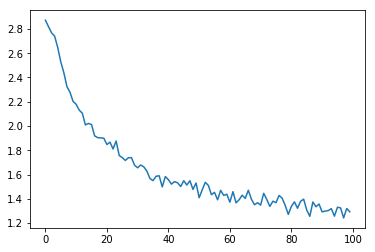

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

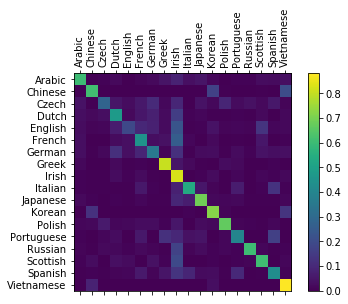

In [34]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

In [46]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.61) Russian
(-1.80) Irish
(-1.88) Czech

> Jackson
(-0.64) Scottish
(-0.98) English
(-3.87) Czech

> Satoshi
(-1.17) Italian
(-1.17) Japanese
(-2.28) Polish
